In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import log
from timeit import default_timer as timer
from sklearn.datasets import make_low_rank_matrix

%matplotlib inline
# np.random.seed(1)

## Helper functions

In [2]:
def load_image(fname):
    return cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

def resize_image(img, dim):
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def get_omega(A, k, p=0):
    """
    k: rank
    p: oversampling
    """
    return np.random.normal(0, 1, (A.shape[1], k+p))

## Load sample image

In [3]:
A = load_image("jupiter.jpg")

## Different Algorithms

In [4]:
from stage_a import *
from stage_b import *

# Algorithms 4.3 and 5.1
# 4.3 becomes 4.1 when q=0
def combo1(A, k, p, q):
    
    Omega = get_omega(A, k, p)
    Q = power_iters(A, Omega, q)
    
    return *direct_svd(A, Q), Q
    
# Algorithms 4.1 and 5.2

def combo2(A, k, p, q):
    Omega = get_omega(A, k, p)
    Q = power_iters(A, Omega, q)

    return *row_extract_svd(A, Q, k, p), Q



## Benchmarks

In [5]:
%%time
U, S, V = np.linalg.svd(A, full_matrices=False)

CPU times: total: 22.8 s
Wall time: 4.04 s


In [6]:
%%time
rU, rS, rV, _ = combo1(A, k=50, p=10, q=2)

CPU times: total: 719 ms
Wall time: 218 ms


In [7]:
%%time
rU, rS, rV, _ = combo2(A, k=50, p=10, q=2)

CPU times: total: 156 ms
Wall time: 182 ms


## Image Compression SVD vs randomized-SVD

In [8]:
def compress_image(U, s, V, r):
    return (U[:,:r].dot(s[:r, np.newaxis]*V[:r,:])).astype(int)

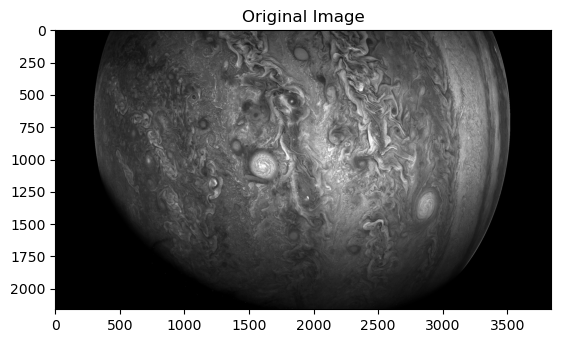

In [9]:
plt.figure()
plt.imshow(A, cmap="gray")
plt.title("Original Image")
plt.show()

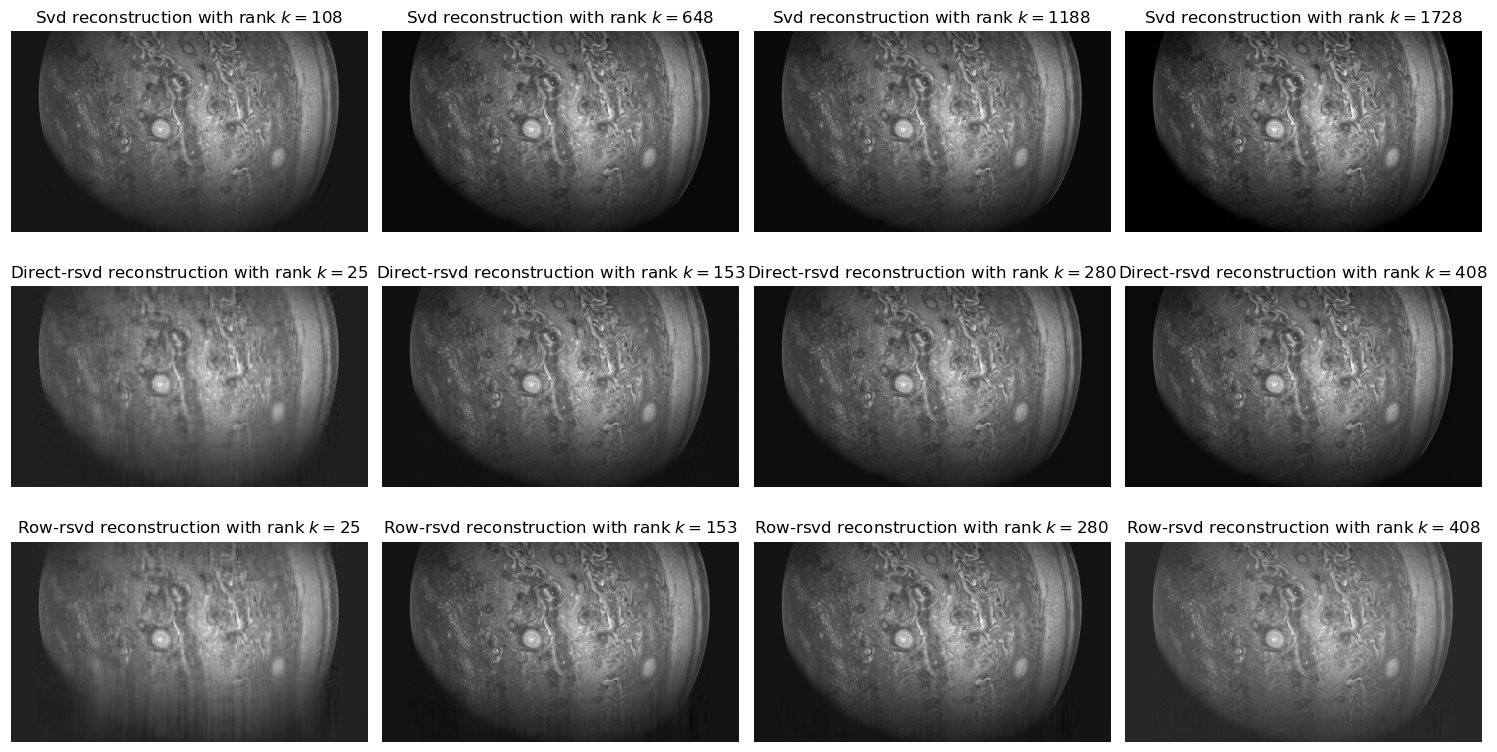

In [10]:
ncols = 4
fig, ax = plt.subplots(nrows=3, ncols=ncols, figsize=(15, 8))
for i, svd_type in enumerate(["svd", "direct-rsvd", "row-rsvd"]):
    if svd_type == "svd":
        U, S, V = np.linalg.svd(A, full_matrices=False)
    elif svd_type == "direct-rsvd":
        U, S, V, Q = combo1(A, k=500, p=10, q=2)
    else:
        U, S, V, Q = combo2(A, k=500, p=10, q=2)
    for j, f in enumerate(np.linspace(0.05, 0.8, ncols)):
        rank = int(f*len(S))
        compressed = compress_image(U, S, V, rank)
        ax[i, j].imshow(compressed, cmap="gray")
        ax[i, j].set_title(f"{svd_type.capitalize()} reconstruction with rank $k={rank}$")
        ax[i, j].axis("off")
plt.tight_layout()
plt.show()

## Singular value ($\sigma$) decay

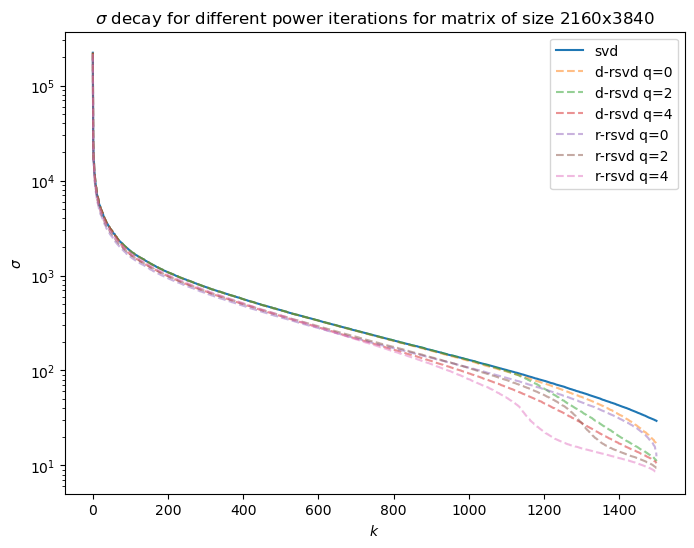

In [11]:
k = 1500
max_ = k
p = 0
plt.figure(figsize=(8, 6))
U, S, V = np.linalg.svd(A, full_matrices=False)
s = S.flatten()
plt.semilogy(s[:k][:max_], label="svd")

for svd_type, combo in zip(["d-rsvd", "r-rsvd"], [combo1, combo2]):
    for q in range(0, 5, 2):
        U, S, V, _ = combo(A, k=k, p=p, q=q)
        s = S.flatten()
        plt.semilogy(s[:max_], label=f"{svd_type} q={q}", alpha=0.5, linestyle="--")
plt.legend()
plt.ylabel("$\sigma$")
plt.xlabel("$k$")
plt.title(f"$\sigma$ decay for different power iterations for matrix of size {A.shape[0]}x{A.shape[1]}")
plt.show()

## Approximation Error (Stage A) for varying ranks (k), power iterations (q), and oversamples (p)
$$
\| A - Q Q^T A \|_2 > \sigma_{k+1}
$$

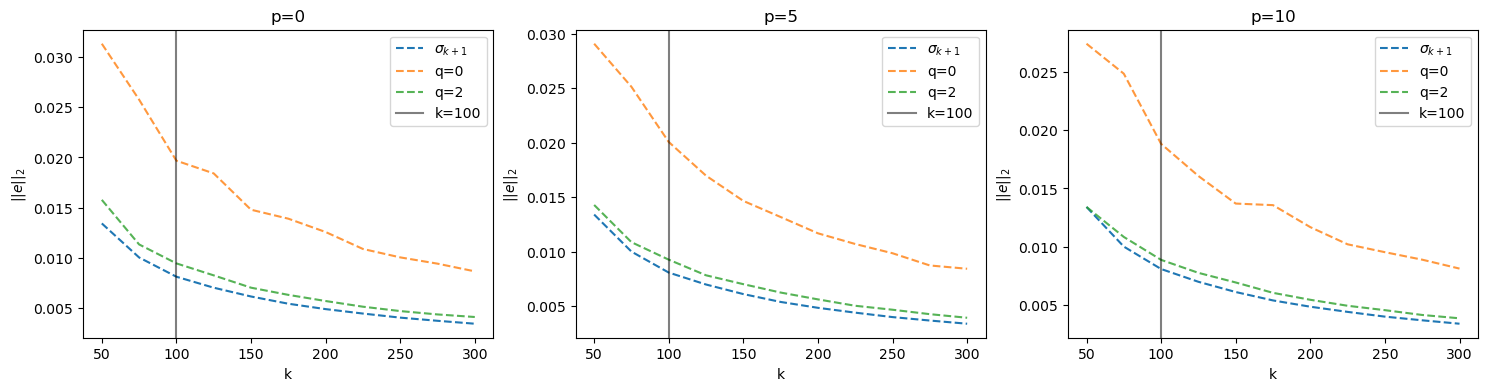

In [12]:
def err1(A, Q):
    return np.linalg.norm(A - (Q @ Q.T @ A), ord=2)

p = 10
q = 1
cutoff = 100
ranks = np.arange(50, 301, 25)
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
svd_norms = []
U, S, V = np.linalg.svd(A, full_matrices=False)
norm_A = np.linalg.norm(A, ord=2)
svd_norms = S.flatten()[ranks]
# for k in ranks:
#     reconstructed = compress_image(U, S, V, k)
    # svd_norms.append(err(A, reconstructed))
for i, p in enumerate([0, 5, 10]):
    ax[i].plot(ranks, svd_norms/norm_A, label="$\sigma_{k+1}$", linestyle="--")
    for q in range(0, 3, 2):
        q_norms = []
        for k in ranks:
            Omega = get_omega(A, k, p)
            Q = power_iters(A, Omega, q)
            q_norms.append(err1(A, Q))
        ax[i].plot(ranks, q_norms/norm_A, label=f"q={q}", linestyle="--", alpha=.8)
    ax[i].axvline(x=cutoff, color="black", alpha=.5, label=f"k={cutoff}")
    ax[i].set_title(f"p={p}")
    ax[i].legend()
    ax[i].set_xlabel("k")
    ax[i].set_ylabel("$\|\|e\|\|_2$")
plt.show()

del U, S, V

## Approximation Error (Reconstruction) for varying ranks (k), power iterations (q), and oversamples (p)
$$
\|A - U \Sigma_k V^T\|_F
$$

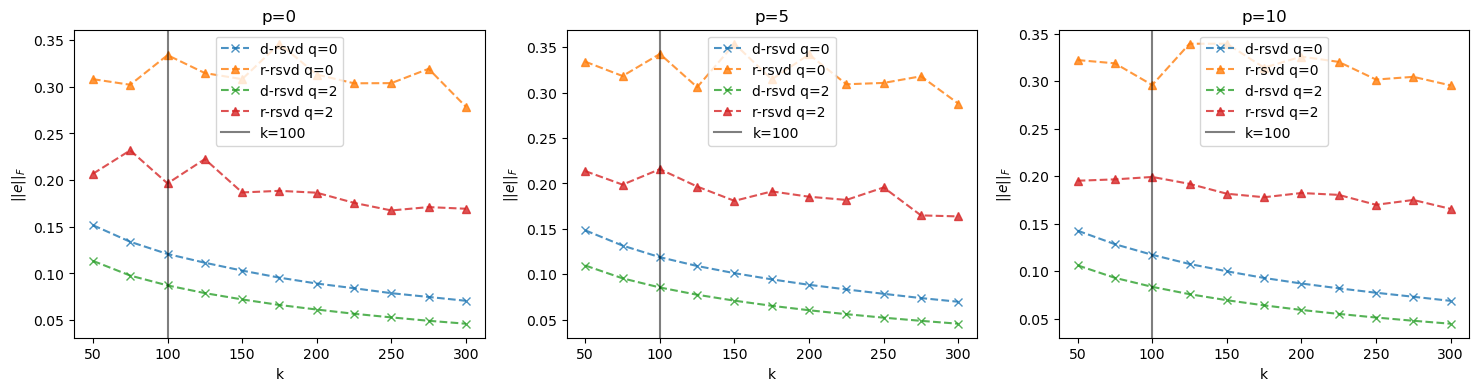

In [13]:
def err2(A, reconstructed):
    return np.linalg.norm(A - reconstructed, ord="fro")
p = 10
q = 1
cutoff = 100
ranks = np.arange(50, 301, 25)
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
norm_A = np.linalg.norm(A, ord="fro")
# for k in ranks:
#     reconstructed = compress_image(U, S, V, k)
    # svd_norms.append(err(A, reconstructed))
for i, p in enumerate([0, 5, 10]):
    for q in range(0, 3, 2):
        d_rsvd_norms = []
        r_rsvd_norms = []
        for k in ranks:
            U, S, V, Q = combo1(A, k=k, p=p, q=q)
            reconstructed = compress_image(U, S, V, len(S))
            d_rsvd_norms.append(err2(A, reconstructed))
            U, S, V, Q = combo2(A, k=k, p=p, q=q)
            reconstructed = compress_image(U, S, V, len(S))
            r_rsvd_norms.append(err2(A, reconstructed))
        ax[i].plot(ranks, d_rsvd_norms/norm_A, label=f"d-rsvd q={q}", linestyle="--", alpha=.8, marker="x")
        ax[i].plot(ranks, r_rsvd_norms/norm_A, label=f"r-rsvd q={q}", linestyle="--", alpha=.8, marker="^")
    ax[i].axvline(x=cutoff, color="black", alpha=.5, label=f"k={cutoff}")
    ax[i].set_title(f"p={p}")
    ax[i].legend()
    ax[i].set_xlabel("k")
    # ax[i].set_yscale("log")
    ax[i].set_ylabel("$\|\|e\|\|_F$")
plt.show()

del U, S, V

## Computation time SVD vs R-SVD for a different sized matrices

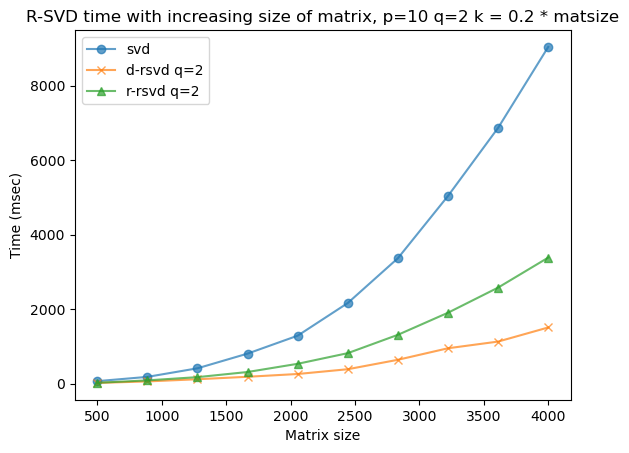

In [14]:
q = 2
p = 10
times1 = []
times2 = []
times3 = []
matsizes = np.linspace(500, 4000, 10).astype(int)
for i in matsizes:
    k = int(.2 * i)
    A_ = make_low_rank_matrix(i, i, effective_rank=k)

    st = timer()
    np.linalg.svd(A_, full_matrices=False)
    times1.append((timer() - st) * 1000)

    st = timer()
    combo1(A_, k=k, p=p, q=q)
    times2.append((timer() - st) * 1000)
    
    st = timer()
    combo2(A_, k=k, p=p, q=q)
    times3.append((timer() - st) * 1000)

plt.figure()
plt.plot(matsizes, times1, marker="o", label="svd", alpha=0.7)
plt.plot(matsizes, times2, marker="x", label="d-rsvd q=2", alpha=0.7)
plt.plot(matsizes, times3, marker="^", label="r-rsvd q=2", alpha=0.7)
plt.xlabel("Matrix size")
plt.ylabel("Time (msec)")
plt.title(f"R-SVD time with increasing size of matrix, p={p} q={q} k = 0.2 * matsize")
plt.legend()
plt.show()

## Computation time R-SVD for a low rank matrix with power iterations (q = 2)

In [ ]:
q = 2
p = 10
effective_rank = 100
A_ = make_low_rank_matrix(2000, 2000, effective_rank=effective_rank)

st = timer()
np.linalg.svd(A_, full_matrices=False)
svd_t = (timer() - st) * 1000

ranks = np.arange(30, 601, 30)
times1 = []
times2 = []
import scipy.linalg.interpolative.svd as id_svd
for k in ranks:
    
    st = timer()
    combo1(A_, k=k, p=p, q=q)
    times1.append((timer() - st) * 1000)
    
    st = timer()
    # combo2(A_, k=k, p=p, q=q)
    id_svd(A_, eps_or_k=k)
    times2.append((timer() - st) * 1000)

plt.figure()
plt.axhline(y=svd_t, color="red", linestyle="--", label="svd")
plt.axvline(x=effective_rank, color="black", linestyle="--", label=f"k={effective_rank}")
plt.plot(ranks, times1, marker="o", label="d-rsvd q=2", alpha=0.7)
plt.plot(ranks, times2, marker="^", label="r-rsvd q=2", alpha=0.7)
plt.xlabel("k")
plt.ylabel("Time (msec)")
plt.title(f"R-SVD time with increasing ranks for matrix of size {A_.shape[0]}x{A_.shape[1]}")
plt.legend()
plt.show()